# XGBoost prediction model, parameter tuning and variable importance 

Useful info: <br>
XGBoost: https://xgboost.readthedocs.io/en/stable/R-package/xgboostPresentation.html (R package for training an XGBoost model) <br>
Caret: https://topepo.github.io/caret/ (R package for training different machine learning models) <br>
MetaboLights: https://www.ebi.ac.uk/metabolights/ (database for metabolomics experiments).

In [186]:
# last update 
Sys.time()

[1] "2022-07-25 15:18:53 CEST"

In [ ]:
install.packages("xgboost")
install.packages("caret")
install.packages("dplyr")
install.packages("pROC")

In [182]:
# load libraries
suppressPackageStartupMessages(suppressWarnings({
library("caret")
library("xgboost")
library("mltools")
library("dplyr")
library("pROC")
}))

In [3]:
# an example of preprocessed metabolomics data in the Metabolights database
# more info at https://www.ebi.ac.uk/metabolights/MTBLS28/descriptors
ft_url <- 'https://www.ebi.ac.uk/metabolights/ws/studies/MTBLS28/download/nD0G7cLIiw?file=m_mtbls28_POS_v2_maf.tsv'

In [4]:
# metadata
md_url <- 'https://www.ebi.ac.uk/metabolights/ws/studies/MTBLS28/download/nD0G7cLIiw?file=s_mtbls28.txt'

In [5]:
# Preprocessed feature table
ft <- read.table(ft_url, sep = '\t', row.names = NULL, header = T, check.names = F)

In [6]:
# create unique id consisting of m/z_rt
ft$feature <- paste(ft$mass_to_charge, ft$retention_time, sep = '_')

In [7]:
rownames(ft) <- ft$feature

In [8]:
# remove extra columns
ft <- ft[,-c(1:21)]

In [9]:
ft <- ft[,-ncol(ft)]

In [10]:
# transpose
ft <- t(ft)

In [12]:
dim(ft)

[1] 1005 1807

In [11]:
# import metadata
md <- read.table(md_url, sep = '\t', row.names = NULL, header = T, check.names = F)

In [13]:
md <- md[md$`Sample Name`%in% rownames(ft),]

In [14]:
rownames(md) <- md$`Sample Name`

In [15]:
dim(md)

[1] 1005   21

In [16]:
table(md$`Factor Value[Sample Type]`)


   Case Control 
    469     536 

In [17]:
md <- md[match(rownames(ft),rownames(md)),]

In [18]:
identical(rownames(md),rownames(ft))

[1] TRUE

In [19]:
# we are going to predict a binary class, lung cancer vs control
md$class <- ifelse(md$`Factor Value[Sample Type]`=='Control',0,1)

In [20]:
table(md$class)


  0   1 
536 469 

In [21]:
table(is.na(ft))


  FALSE 
1816035 

In [22]:
# convert zeros to NAs (if any)
ft <- dplyr::na_if(ft, 0)

In [23]:
table(is.na(ft))


  FALSE    TRUE 
1814282    1753 

In [24]:
# keep features with less than 5% NAs across samples
ft <- ft[,which(colMeans(is.na(ft)) < 0.05)]

dim(ft)

[1] 1005 1801

In [25]:
# scale feature table
ft <- scale(ft, center = T, scale = T)

In [26]:
df_ft <- cbind(ft,md[,c('class')])

In [27]:
# Set random seed to make results reproducible
set.seed(1234)
trainIndex <- caret::createDataPartition(df_ft[,ncol(df_ft)], p = 0.8, 
                                  list = FALSE, 
                                  times = 1)

ftTrain <- df_ft[trainIndex,]
ftTest  <- df_ft[-trainIndex,]

dim(ftTrain)
dim(ftTest)

[1]  804 1802

[1]  201 1802

In [28]:
table(ftTrain[,ncol(ftTrain)])
table(ftTest[,ncol(ftTrain)])


  0   1 
426 378 


  0   1 
110  91 

In [32]:
train_x <- ftTrain[,-ncol(ftTrain)]
train_y <- as.factor(ftTrain[,ncol(ftTrain)])
test_x <- ftTest[,-ncol(ftTest)]
test_y <- as.factor(ftTest[,ncol(ftTest)])

In [33]:
dim(train_x)
table(train_y)
dim(test_x)
table(test_y)

[1]  804 1801

train_y
  0   1 
426 378 

[1]  201 1801

test_y
  0   1 
110  91 

First, we perform the analysis without tuning the parameters, by using default/recommended parameters.

In [34]:
grid_default <- expand.grid(
  nrounds = 500,
  max_depth = 6,
  eta = 0.3,
  gamma = 0,
  colsample_bytree = 1,
  min_child_weight = 1,
  subsample = 1
)

train_control <- caret::trainControl(
  method = "none",
  verboseIter = FALSE,
  allowParallel = FALSE # FALSE for reproducible results 
)

set.seed(1234)
xgb_base <- caret::train(
  x = train_x, y = train_y,
  trControl = train_control,
  tuneGrid = grid_default,
  method = "xgbTree",
  verbose = TRUE
)

In [35]:
xgb_base

eXtreme Gradient Boosting 

 804 samples
1801 predictors
   2 classes: '0', '1' 

No pre-processing
Resampling: None 

In [36]:
# predict on test data
predicted_base <- predict(xgb_base, test_x)
# performance
confusionMatrix(data = predicted_base, reference = test_y, positive = '1', mode = 'everything')

Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 88 24
         1 22 67
                                          
               Accuracy : 0.7711          
                 95% CI : (0.7068, 0.8273)
    No Information Rate : 0.5473          
    P-Value [Acc > NIR] : 3.602e-11       
                                          
                  Kappa : 0.5373          
                                          
 Mcnemar's Test P-Value : 0.8828          
                                          
            Sensitivity : 0.7363          
            Specificity : 0.8000          
         Pos Pred Value : 0.7528          
         Neg Pred Value : 0.7857          
              Precision : 0.7528          
                 Recall : 0.7363          
                     F1 : 0.7444          
             Prevalence : 0.4527          
         Detection Rate : 0.3333          
   Detection Prevalence : 0.4428          
      Balanced Accuracy : 0.7681    

In [38]:
# predict on test data
prediction_probs_base <- predict(xgb_base, test_x, type = "prob")
# ROC
ROC_base <- pROC::roc(test_y, prediction_probs_base[,2]) # for class 1 (that is Case)
# Area Under Curve (AUC)
AUC_base <- pROC::auc(ROC_base)

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "Accuracy:  0.771144278606965"

[1] "Area Under the Curve:  0.836263736263736"

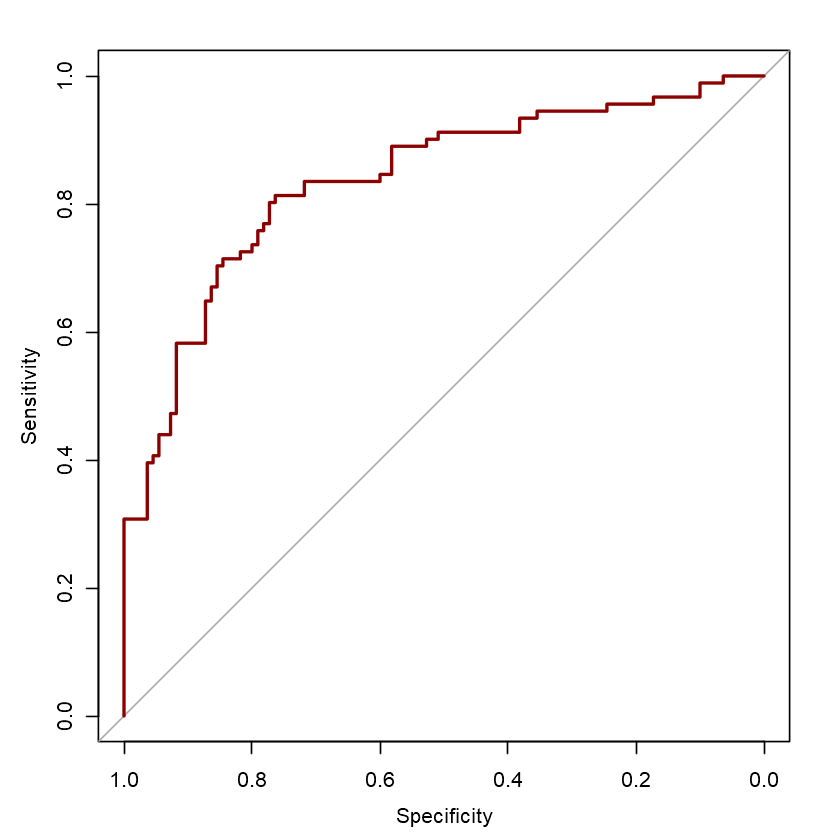

In [39]:
# plot ROC curve
plot(ROC_base, col = "darkred", main = NULL)
# print performance
paste("Accuracy: ", mean(test_y == round(prediction_probs_base[,2], digits = 0)))
paste("Area Under the Curve: ", AUC_base)

In [41]:
# Calculate Matthews correlation coefficient (MCC) 
mltools::mcc(preds = predicted_base, actuals = test_y)

[1] 0.5373923

### Tuning parameters<br>
We now train model's parameters in 10 fold cross-validation<br>

Tuning Number of Iterations and the Learning Rate

In [42]:
nrounds <- 1000 # To get reasonable running time while testing many hyperparameter combinations 

In [43]:
tune_grid <- expand.grid(
  nrounds = seq(from = 200, to = nrounds, by = 50),
  eta = c(0.025, 0.05, 0.1, 0.3),
  max_depth = seq(from = 2, to = 10, by = 2),
  #max_depth = 6,
  gamma = 0,
  colsample_bytree = 1,
  min_child_weight = 1,
  subsample = 1
)


In [44]:
tune_control <- caret::trainControl(
  method = "cv", # cross-validation
  number = 10, # number of folds
  repeats = NA,
  verboseIter = FALSE,
  allowParallel = FALSE # FALSE for reproducible results 
)


In [45]:
set.seed(1234)
xgb_tune <- caret::train(
  x = train_x, y = train_y,
  trControl = tune_control,
  tuneGrid = tune_grid,
  method = "xgbTree",
  verbose = TRUE
)


In [46]:
xgb_tune$bestTune

,nrounds,max_depth,eta,gamma,colsample_bytree,min_child_weight,subsample
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
273,200,4,0.3,0,1,1,1


Tuning Maximum Depth and Minimum Child Weight

In [47]:
tune_grid2 <- expand.grid(
  nrounds = seq(from = 50, to = nrounds, by = 50),
  eta = xgb_tune$bestTune$eta,
  max_depth = ifelse(xgb_tune$bestTune$max_depth == 2, c(xgb_tune$bestTune$max_depth:10),
  xgb_tune$bestTune$max_depth - 1:xgb_tune$bestTune$max_depth + 1),
  #max_depth = seq(from = 2, to = 10, by = 1),
  gamma = 0,
  colsample_bytree = 1,
  min_child_weight = c(1, 2, 3),
  subsample = 1
)


In [48]:
set.seed(1234)
xgb_tune2 <- caret::train(
  x = train_x, y = train_y,
  trControl = tune_control,
  tuneGrid = tune_grid2,
  method = "xgbTree",
  verbose = TRUE
)


In [49]:
xgb_tune2$bestTune

,nrounds,max_depth,eta,gamma,colsample_bytree,min_child_weight,subsample
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4,200,4,0.3,0,1,1,1


Tuning Column and Row Sampling

In [50]:
tune_grid3 <- expand.grid(
  nrounds = seq(from = 50, to = nrounds, by = 50),
  eta = xgb_tune$bestTune$eta,
  max_depth = xgb_tune2$bestTune$max_depth,
  gamma = 0,
  colsample_bytree = c(0.4, 0.6, 0.8, 1.0),
  min_child_weight = xgb_tune2$bestTune$min_child_weight,
  subsample = c(0.5, 0.75, 1.0)
)

In [51]:
set.seed(1234)
xgb_tune3 <- caret::train(
  x = train_x, y = train_y,
  trControl = tune_control,
  tuneGrid = tune_grid3,
  method = "xgbTree",
  verbose = TRUE
)


In [52]:
xgb_tune3$bestTune

,nrounds,max_depth,eta,gamma,colsample_bytree,min_child_weight,subsample
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
89,450,4,0.3,0,0.6,1,0.75


Tuning Gamma

In [53]:
tune_grid4 <- expand.grid(
  nrounds = seq(from = 50, to = nrounds, by = 50),
  eta = xgb_tune$bestTune$eta,
  max_depth = xgb_tune2$bestTune$max_depth,
  gamma = c(0, 0.05, 0.1, 0.5, 0.7, 0.9, 1.0),
  colsample_bytree = xgb_tune3$bestTune$colsample_bytree,
  min_child_weight = xgb_tune2$bestTune$min_child_weight,
  subsample = xgb_tune3$bestTune$subsample
)

In [54]:
set.seed(1234)
xgb_tune4 <- caret::train(
  x = train_x, y = train_y,
  trControl = tune_control,
  tuneGrid = tune_grid4,
  method = "xgbTree",
  verbose = TRUE
)


In [55]:
xgb_tune4$bestTune

,nrounds,max_depth,eta,gamma,colsample_bytree,min_child_weight,subsample
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
28,400,4,0.3,0.05,0.6,1,0.75


Reducing the Learning Rate

In [56]:
tune_grid5 <- expand.grid(
  nrounds = seq(from = 50, to = 10000, by = 50),
  eta = c(0.01, 0.015, 0.025, 0.05, 0.1),
  max_depth = xgb_tune2$bestTune$max_depth,
  gamma = xgb_tune4$bestTune$gamma,
  colsample_bytree = xgb_tune3$bestTune$colsample_bytree,
  min_child_weight = xgb_tune2$bestTune$min_child_weight,
  subsample = xgb_tune3$bestTune$subsample
)


In [57]:
set.seed(1234)
xgb_tune5 <- caret::train(
    x = train_x, y = train_y,
  trControl = tune_control,
  tuneGrid = tune_grid5,
  method = "xgbTree",
  verbose = TRUE
)

In [58]:
xgb_tune5$bestTune

,nrounds,max_depth,eta,gamma,colsample_bytree,min_child_weight,subsample
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
899,4950,4,0.1,0.05,0.6,1,0.75


Fitting the final model using the best parameters from the previous step

In [59]:
final_grid <- expand.grid(
  nrounds = xgb_tune5$bestTune$nrounds,
  eta = xgb_tune5$bestTune$eta,
  max_depth = xgb_tune5$bestTune$max_depth,
  gamma = xgb_tune5$bestTune$gamma,
  colsample_bytree = xgb_tune5$bestTune$colsample_bytree,
  min_child_weight = xgb_tune5$bestTune$min_child_weight,
  subsample = xgb_tune5$bestTune$subsample
)

In [60]:
set.seed(1234)
xgb_model_final <- caret::train(
  x = train_x, y = train_y,
  trControl = train_control,
  tuneGrid = final_grid,
  method = "xgbTree",
  verbose = TRUE
)

In [61]:
xgb_model_final$bestTune

,nrounds,eta,max_depth,gamma,colsample_bytree,min_child_weight,subsample
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,4950,0.1,4,0.05,0.6,1,0.75


In [62]:
# predict on test data
predicted_final <- predict(xgb_model_final, test_x)

In [63]:
confusionMatrix(data = predicted_final, reference = test_y, positive = '1', mode = 'everything')

Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 92 19
         1 18 72
                                         
               Accuracy : 0.8159         
                 95% CI : (0.7553, 0.867)
    No Information Rate : 0.5473         
    P-Value [Acc > NIR] : 1.024e-15      
                                         
                  Kappa : 0.6282         
                                         
 Mcnemar's Test P-Value : 1              
                                         
            Sensitivity : 0.7912         
            Specificity : 0.8364         
         Pos Pred Value : 0.8000         
         Neg Pred Value : 0.8288         
              Precision : 0.8000         
                 Recall : 0.7912         
                     F1 : 0.7956         
             Prevalence : 0.4527         
         Detection Rate : 0.3582         
   Detection Prevalence : 0.4478         
      Balanced Accuracy : 0.8138         
              

In [131]:
# Calculate Matthews correlation coefficient (MCC) 
mltools::mcc(preds = predicted_final, actuals = test_y)

[1] 0.6282003

In [70]:
prediction_roc_curve <- predict(xgb_model_final, test_x, type = "prob")

ROC_xgboost <- pROC::roc(test_y, prediction_roc_curve[,2]) # for class 1 (that is Case)
# Area Under Curve (AUC) (higher -> better)
ROC_auc <- pROC::auc(ROC_xgboost)

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "Accuracy:  0.81592039800995"

[1] "Area under the curve:  0.868131868131868"

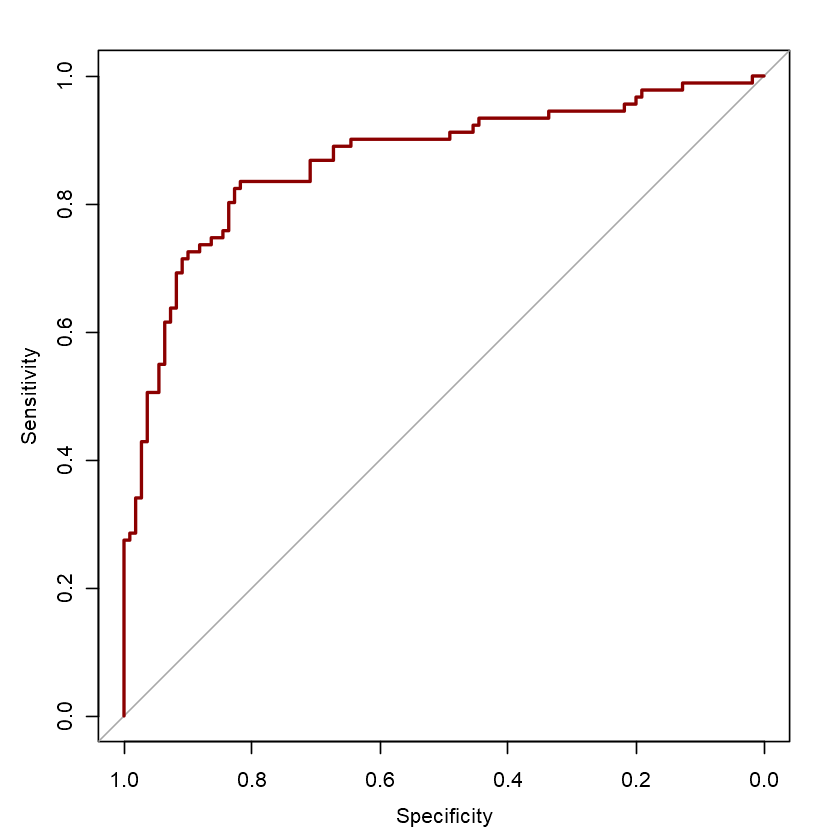

In [71]:
# plot ROC curve
plot(ROC_xgboost, col = "darkred", main = NA)
# print performance
paste("Accuracy: ", mean(test_y == round(prediction_roc_curve[,2], digits = 0)))
paste("Area under the curve: ", ROC_auc)

As we can see, we have improved the performance from MCC 0.537 to 0.628 (the other performance metrics show the improvement as well).

## Variable importance

In this section we explore the importance of features that contributed to the prediction. There are many ways to find out which features contribute the most to the predictive model. In the following, we will simply apply the inbuilt function in the caret package. Other useful packages for this purpose exist such as iml (https://cran.r-project.org/web/packages/iml/index.html) and SHAPforxgboost (https://cran.r-project.org/web/packages/SHAPforxgboost/readme/README.html). The SHAP analysis is also included in the xgboost package (see below for this analysis).

In [73]:
# function implemented in caret
var_imp_xgb <- varImp(xgb_model_final, scale = F) # use scale = T to scale to 100
var_imp_xgb

xgbTree variable importance

  only 20 most important variables shown (out of 1801)

                         Overall
264.1215224_23.30921876 0.105408
170.0605916_284.4949518 0.019487
269.1280232_25.77123022 0.013563
268.0786356_247.286278  0.012609
284.1869613_241.953849  0.011432
243.1004849_3.745031639 0.011226
638.3608799_328.1278024 0.010876
542.9586941_34.39494134 0.010722
204.1345526_48.36620651 0.008899
656.2017529_3.99017038  0.008784
478.1720846_1.243665051 0.008774
155.0134266_247.4243894 0.008518
430.0650222_118.8607814 0.008056
291.1642398_109.6047932 0.007408
375.1153219_2.261121688 0.007398
267.0752208_47.5987377  0.007236
486.2571336_125.0351305 0.006485
247.0970455_23.66165344 0.006359
592.3196438_330.9109636 0.006192
261.1110433_236.350325  0.005845

In [74]:
# same as before but using the inbuilt xgboost variable importance (just to show that in caret, the 'Overall' importance 
# is the 'Gain' value of the xgboost package). The higher the value compared to another feature, the more important is the 
# feature that contributed to the prediction
xgboost::xgb.importance(xgb_model_final$finalModel$feature_names, model = xgb_model_final$finalModel)[1:20]

Feature,Gain,Cover,Frequency
<chr>,<dbl>,<dbl>,<dbl>
264.1215224_23.30921876,0.105408380,0.063898204,0.019860973
170.0605916_284.4949518,0.019487437,0.023991735,0.013571665
269.1280232_25.77123022,0.013563151,0.012701865,0.008275405
268.0786356_247.286278,0.012608688,0.010564345,0.002317114
284.1869613_241.953849,0.011432377,0.010909193,0.004965243
243.1004849_3.745031639,0.011225519,0.012317944,0.005296260
638.3608799_328.1278024,0.010876115,0.015148385,0.005958292
542.9586941_34.39494134,0.010722027,0.007926675,0.001986097
204.1345526_48.36620651,0.008899171,0.007353411,0.002648130


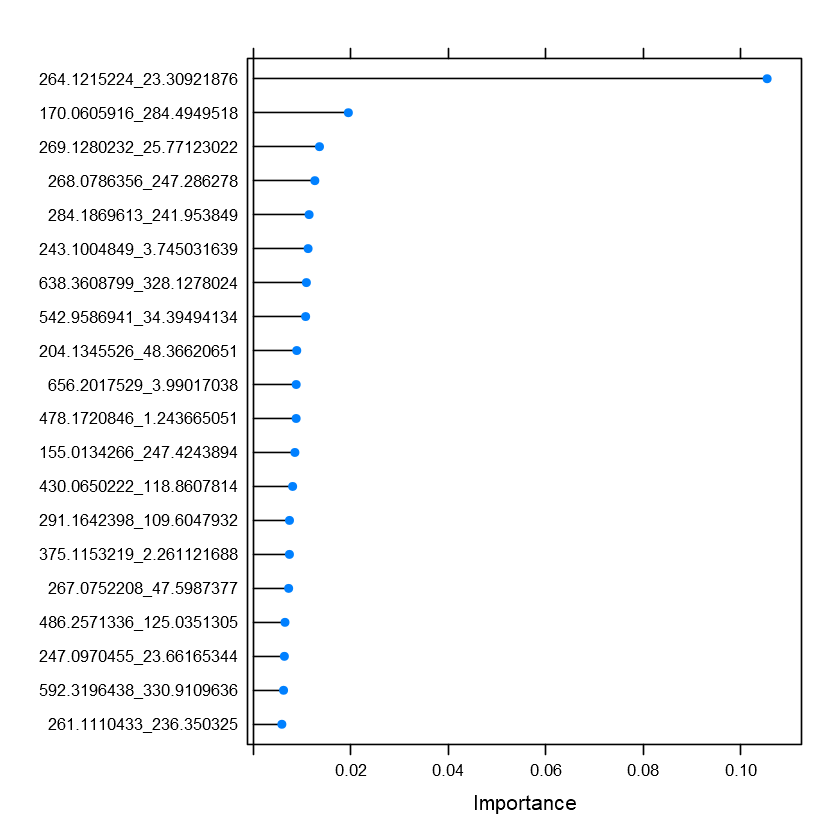

In [75]:
# plot importance
plot(var_imp_xgb, top = 20)

In [76]:
# with scaled values, from 0 to 100
var_imp_xgb_sc <- varImp(xgb_model_final, scale = T)
var_imp_xgb_sc

xgbTree variable importance

  only 20 most important variables shown (out of 1801)

                        Overall
264.1215224_23.30921876 100.000
170.0605916_284.4949518  18.488
269.1280232_25.77123022  12.867
268.0786356_247.286278   11.962
284.1869613_241.953849   10.846
243.1004849_3.745031639  10.650
638.3608799_328.1278024  10.318
542.9586941_34.39494134  10.172
204.1345526_48.36620651   8.443
656.2017529_3.99017038    8.333
478.1720846_1.243665051   8.323
155.0134266_247.4243894   8.081
430.0650222_118.8607814   7.642
291.1642398_109.6047932   7.028
375.1153219_2.261121688   7.018
267.0752208_47.5987377    6.865
486.2571336_125.0351305   6.153
247.0970455_23.66165344   6.032
592.3196438_330.9109636   5.874
261.1110433_236.350325    5.545

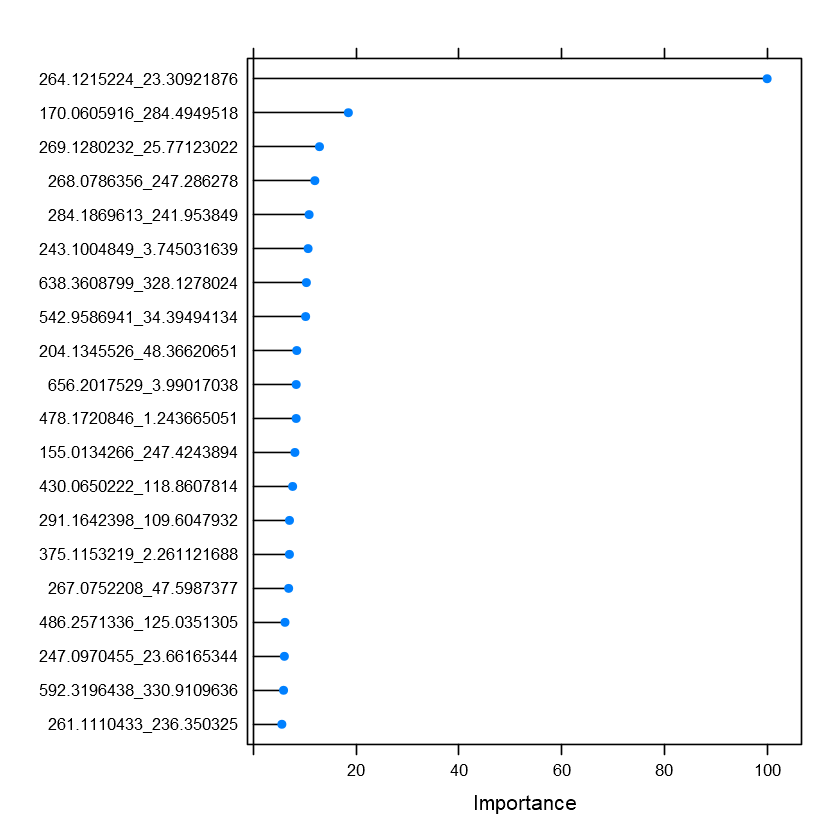

In [77]:
plot(var_imp_xgb_sc, top = 20)

### SHAP analysis.

Visualizing SHAP feature contribution to prediction dependencies on feature value and compare SHAP contributions of different features ('summary' plot).

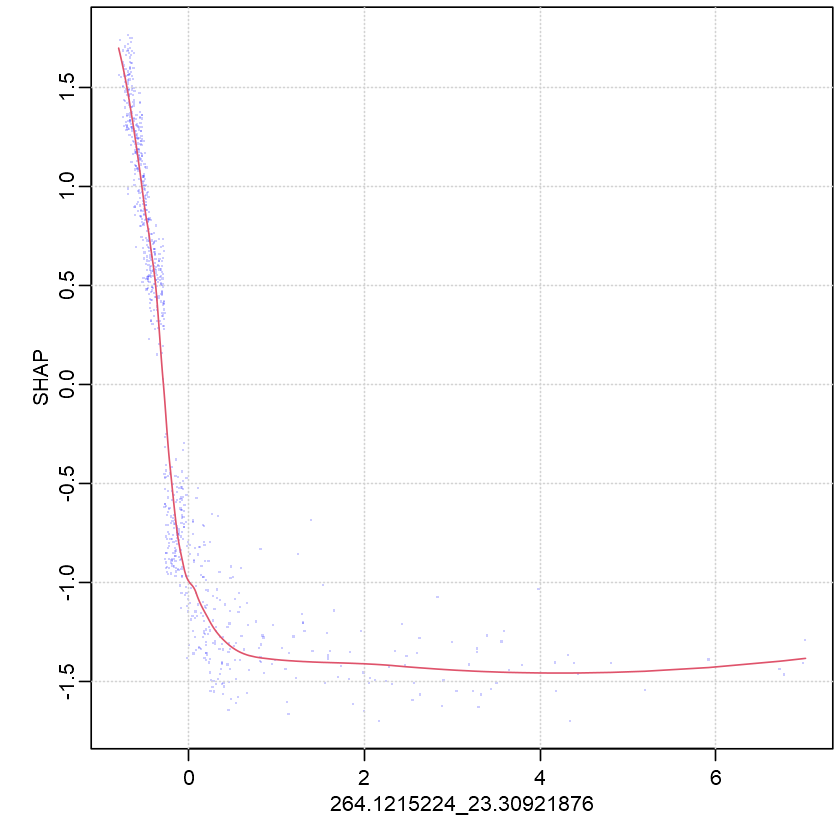

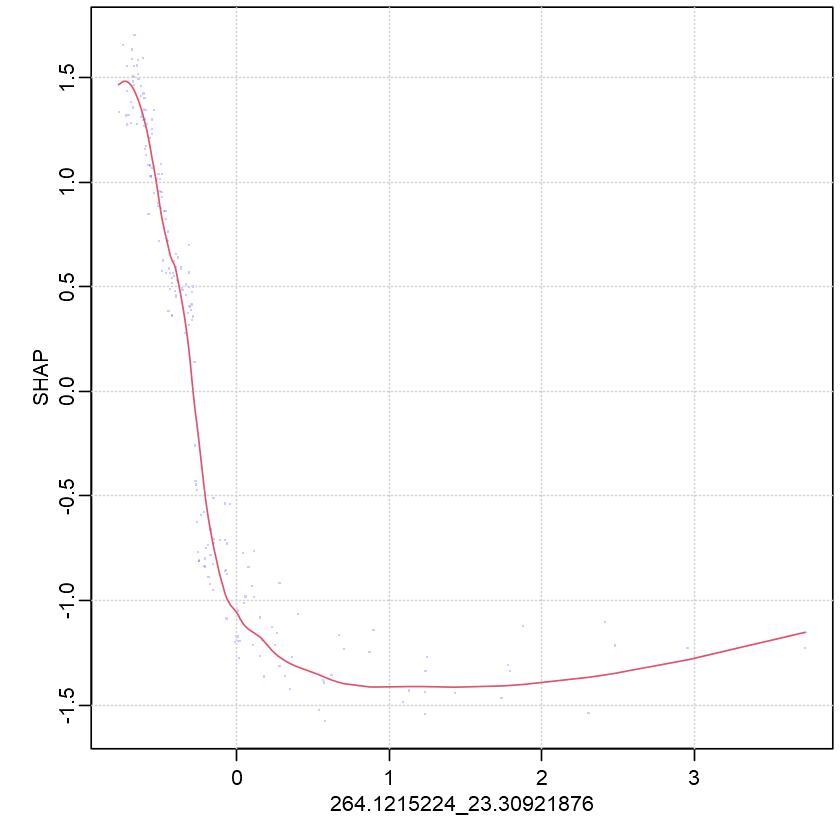

In [183]:
# top most important feature
# https://www.rdocumentation.org/packages/xgboost/versions/1.6.0.1/topics/xgb.plot.shap
xgboost::xgb.plot.shap(model = xgb_model_final$finalModel, data = train_x) # based on train set
xgboost::xgb.plot.shap(model = xgb_model_final$finalModel, data = test_x) # based on test set

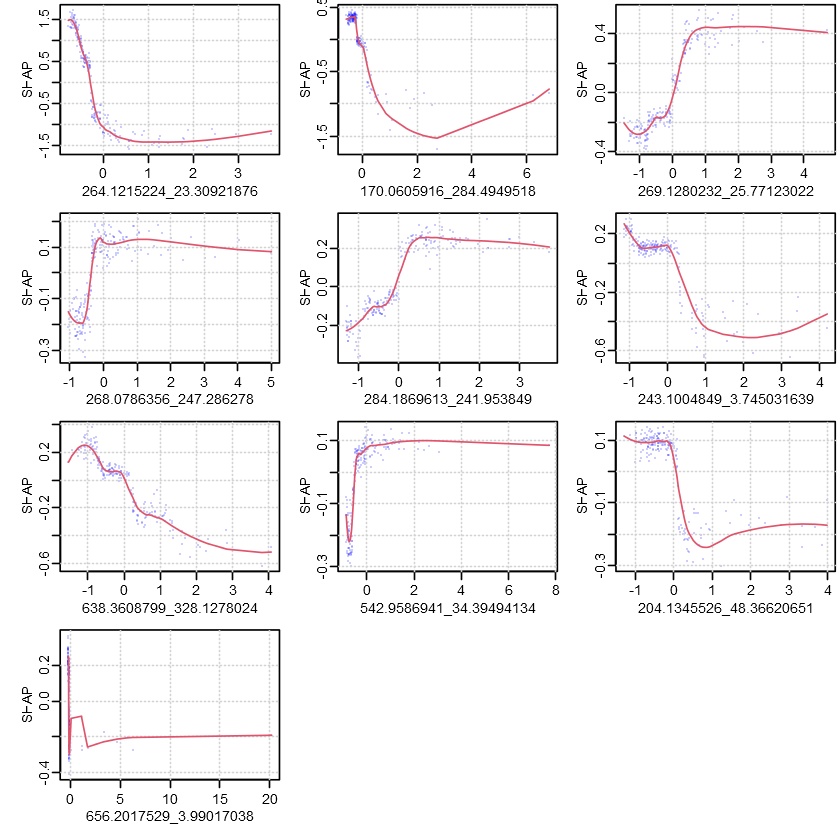

In [184]:
# SHAP values for top 10 features
contr <- predict(xgb_model_final$finalModel, test_x, predcontrib = TRUE)
xgb.plot.shap(test_x, contr, model = xgb_model_final$finalModel, top_n = 10, n_col = 3)

The following is called 'summary' plot. Each point represents one sample from the data and it is produced for each feature, with the points plotted on the SHAP value axis. Each point is coloured based on its feature value. The plot allows us to evaluate which features have a negative or positive contribution on the model prediction, and whether the contribution is different for larger or smaller values of the feature. 

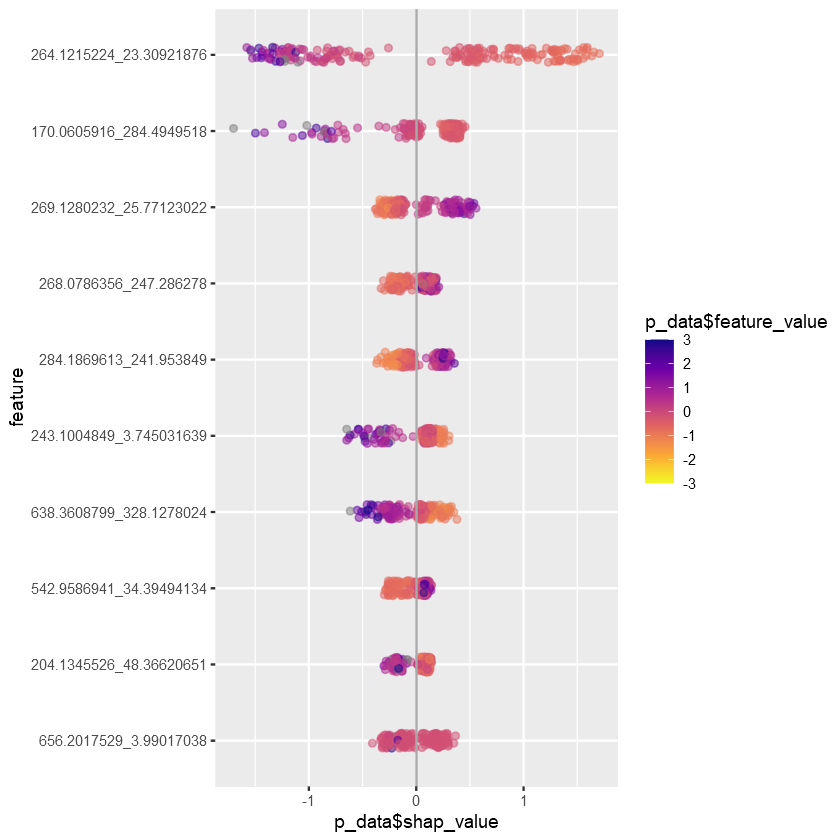

In [185]:
xgb.ggplot.shap.summary(test_x, contr, model = xgb_model_final$finalModel, top_n = 10)

In [128]:
sessionInfo()

R version 4.1.0 (2021-05-18)
Platform: x86_64-w64-mingw32/x64 (64-bit)
Running under: Windows 10 x64 (build 19042)

Matrix products: default

locale:
[1] LC_COLLATE=English_United Kingdom.1252 
[2] LC_CTYPE=English_United Kingdom.1252   
[3] LC_MONETARY=English_United Kingdom.1252
[4] LC_NUMERIC=C                           
[5] LC_TIME=English_United Kingdom.1252    

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] RColorBrewer_1.1-2 igraph_1.2.6       iml_0.10.1         dplyr_1.0.7       
[5] mltools_0.3.5      xgboost_1.4.1.1    caret_6.0-90       lattice_0.20-44   
[9] ggplot2_3.3.5     

loaded via a namespace (and not attached):
 [1] jsonlite_1.7.2       splines_4.1.0        foreach_1.5.1       
 [4] prodlim_2019.11.13   assertthat_0.2.1     stats4_4.1.0        
 [7] globals_0.14.0       ipred_0.9-11         pillar_1.6.3        
[10] backports_1.2.1      glue_1.4.2           pROC_1.18.0         
[13] u